# DS 3000 Final Project
By: Srijith Gomattam, Shrey Patel, Rohin Patel, Parth Shah (DS Group 50)

## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from scipy.stats import randint as sp_randint, uniform, expon
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

## Load Data

In [2]:
# Reading the CSV file
url = "https://data.boston.gov/dataset/7b29c1b2-7ec2-4023-8292-c24f5d8f0905/resource/e4bfe397-6bfc-49c5-9367-c879fac7401d/download/tmp2c96di5h.csv"
data = pd.read_csv(url)

# Displaying the first few rows of the dataset
data.head()

,dispatch_ts,mode_type,location_type,street,xstreet1,xstreet2,x_cord,y_cord,lat,long
0,2015-01-01 00:24:27+00,mv,Intersection,NaN,TRAIN ST,WESTGLOW ST,777243.68,2930930.11,42.289749,-71.052516
1,2015-01-01 03:50:33+00,mv,Street,RIVER ST,WALTER ST,WINTHROP ST,758927.71,2918981.60,42.257078,-71.120106
2,2015-01-01 10:14:13+00,ped,Intersection,NaN,LONDON ST,MERIDIAN ST,780725.19,2961410.17,42.373337,-71.039040
3,2015-01-01 18:23:57+00,bike,Intersection,NaN,OLNEY ST,INWOOD ST,772710.48,2936614.62,42.305412,-71.069164
4,2015-01-01 18:42:19+00,ped,Intersection,NaN,WASHINGTON ST,COLUMBUS AVE,764813.61,2940364.63,42.315808,-71.098291


## EDA

In [3]:
# Cleaning the data

# Filling missing values with 'Unknown' for the street-related columns
data['street'].fillna('Unknown', inplace=True)
data['xstreet1'].fillna('Unknown', inplace=True)
data['xstreet2'].fillna('Unknown', inplace=True)

# Convert 'dispatch_ts' to datetime and extract numeric features
data['dispatch_ts'] = pd.to_datetime(data['dispatch_ts'])
data['hour'] = data['dispatch_ts'].dt.hour
data['day_of_week'] = data['dispatch_ts'].dt.dayofweek
data['month'] = data['dispatch_ts'].dt.month

# Encode categorical variables
label_encoder = LabelEncoder()
categorical_columns = ['location_type', 'street', 'xstreet1', 'xstreet2']
for column in categorical_columns:
    data[column] = label_encoder.fit_transform(data[column].astype(str))
    
# Handle missing values
data = data.ffill()

# Create a copy for later use
data_copy = data

# Check the cleaned data
print("Data info:\n")
data.info()

Data info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35282 entries, 0 to 35281
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   dispatch_ts    35282 non-null  datetime64[ns, UTC]
 1   mode_type      35282 non-null  object             
 2   location_type  35282 non-null  int64              
 3   street         35282 non-null  int64              
 4   xstreet1       35282 non-null  int64              
 5   xstreet2       35282 non-null  int64              
 6   x_cord         35282 non-null  float64            
 7   y_cord         35282 non-null  float64            
 8   lat            35282 non-null  float64            
 9   long           35282 non-null  float64            
 10  hour           35282 non-null  int32              
 11  day_of_week    35282 non-null  int32              
 12  month          35282 non-null  int32              
dtypes: datetime64[ns, UTC](1), float64

In [4]:
# Check the packaging - calculates the number of missing values in each column
missing_values = data.isnull().sum()

# Get data types of each column in the dataset
data_types = data.dtypes

# Look at the bottom of the data
bottom_data = data.tail()

# Checking number of rows and columns in data
shape = data.shape

print("Missing values:\n")
print(missing_values)

print("\nData types:\n")
print(data_types)

print("\nBottom of data:\n")
print(bottom_data)

print("\nShape of data:\n")
print(shape)

Missing values:

dispatch_ts      0
mode_type        0
location_type    0
street           0
xstreet1         0
xstreet2         0
x_cord           0
y_cord           0
lat              0
long             0
hour             0
day_of_week      0
month            0
dtype: int64

Data types:

dispatch_ts      datetime64[ns, UTC]
mode_type                     object
location_type                  int64
street                         int64
xstreet1                       int64
xstreet2                       int64
x_cord                       float64
y_cord                       float64
lat                          float64
long                         float64
hour                           int32
day_of_week                    int32
month                          int32
dtype: object

Bottom of data:

                    dispatch_ts mode_type  location_type  street  xstreet1  \
35277 2023-11-30 14:11:56+00:00        mv              0    1333       367   
35278 2023-11-30 14:55:55+00:00        m

## Data Visualization

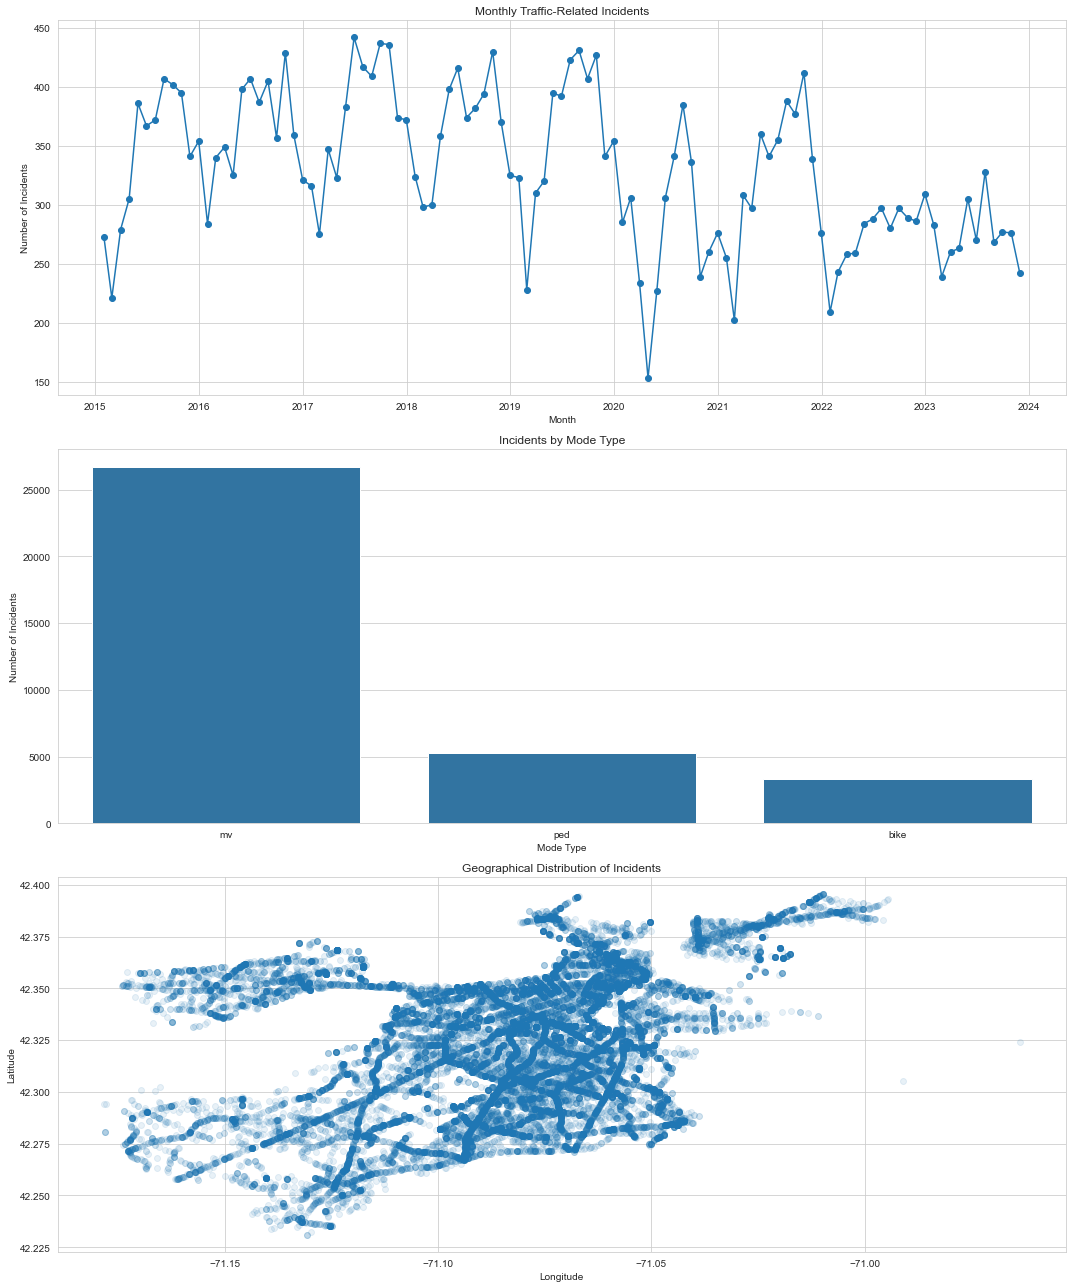

In [5]:
# Set the style for seaborn plots
sns.set_style("whitegrid")

# Prepare a figure with multiple subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 18))

# Line chart of incidents over time (monthly)
data['dispatch_ts'] = pd.to_datetime(data['dispatch_ts'])
monthly_incidents = data.resample('M', on='dispatch_ts').size()
axes[0].plot(monthly_incidents.index.to_pydatetime(), monthly_incidents.values, marker='o', linestyle='-')
axes[0].set_title('Monthly Traffic-Related Incidents')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Number of Incidents')

# Bar chart of incidents by mode_type
sns.countplot(data=data, x='mode_type', ax=axes[1], order=data['mode_type'].value_counts().index)
axes[1].set_title('Incidents by Mode Type')
axes[1].set_xlabel('Mode Type')
axes[1].set_ylabel('Number of Incidents')

# Scatter plot of incidents based on latitude and longitude
axes[2].scatter(data['long'], data['lat'], alpha=0.1)
axes[2].set_title('Geographical Distribution of Incidents')
axes[2].set_xlabel('Longitude')
axes[2].set_ylabel('Latitude')

# Adjust layout and display
plt.tight_layout()
plt.show()

## Modeling and Training

In [6]:
# Using train_test_split with a large test_size to reduce the dataset size while keeping stratification
data_small, _ = train_test_split(data, test_size=0.7, stratify=data['mode_type'], random_state=42)

# Preparing the smaller dataset for modeling
X_small = data_small.drop(['mode_type', 'dispatch_ts'], axis=1)  # Adjust based on your actual column names
y_small = data_small['mode_type']

# Splitting the smaller dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_small, y_small, test_size=0.2, random_state=7)


In [7]:
# Creating and fitting the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=7)
rf_model.fit(X_train, y_train)

# Making predictions and evaluating the model
rf_predictions = rf_model.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, rf_predictions))
print(classification_report(y_test, rf_predictions, zero_division=1))

Random Forest Accuracy: 0.7614548889938593
              precision    recall  f1-score   support

        bike       1.00      0.00      0.00       211
          mv       0.76      1.00      0.86      1612
         ped       1.00      0.00      0.00       294

    accuracy                           0.76      2117
   macro avg       0.92      0.33      0.29      2117
weighted avg       0.82      0.76      0.66      2117



In [8]:
# Creating and fitting the GBM model
gbm_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbm_model.fit(X_train, y_train)

# Making predictions and evaluating the model
gbm_predictions = gbm_model.predict(X_test)
print("GBM Accuracy:", accuracy_score(y_test, gbm_predictions))
print(classification_report(y_test, gbm_predictions))

GBM Accuracy: 0.7590930562116203
              precision    recall  f1-score   support

        bike       0.00      0.00      0.00       211
          mv       0.76      1.00      0.86      1612
         ped       0.33      0.01      0.02       294

    accuracy                           0.76      2117
   macro avg       0.37      0.34      0.29      2117
weighted avg       0.63      0.76      0.66      2117



In [9]:
# Creating and fitting the Non-Linear SVC model
svc_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svc_model.fit(X_train, y_train)

# Making predictions and evaluating the model
svc_predictions = svc_model.predict(X_test)
print("Non-Linear SVC Accuracy:", accuracy_score(y_test, svc_predictions))
print(classification_report(y_test, svc_predictions, zero_division=1))

Non-Linear SVC Accuracy: 0.7614548889938593
              precision    recall  f1-score   support

        bike       1.00      0.00      0.00       211
          mv       0.76      1.00      0.86      1612
         ped       1.00      0.00      0.00       294

    accuracy                           0.76      2117
   macro avg       0.92      0.33      0.29      2117
weighted avg       0.82      0.76      0.66      2117



## Let's make these models better...

## Tune random forest model

In [10]:
# Defining the parameter grid for Random Search
param_dist = {
    'n_estimators': [100, 150, 200, 300],
    'max_depth': [4, 5, 6, 7, 8, 9],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5, 10]
}

# Random Forest Classifier model
rf_model = RandomForestClassifier(random_state=7)

# Randomized Search with cross-validation
random_search = RandomizedSearchCV(rf_model, param_distributions=param_dist, n_iter=10, cv=5, random_state=7)

# Fitting the Random Search to the data
random_search.fit(X_train, y_train)

# Best parameters
best_params = random_search.best_params_
best_score = random_search.best_score_

best_params, best_score

({'n_estimators': 300,
  'min_samples_split': 2,
  'min_samples_leaf': 2,
  'max_depth': 9},
 0.7563482106681375)

## Tune GBM model

In [11]:
# Setting up the parameters for Random Search
param_dist_gbm = {
    "n_estimators": [75, 100], 
    "learning_rate": [0.05, 0.15], 
    "max_depth": [4, 5], 
    "min_samples_split": [4, 5],
    "min_samples_leaf": [3, 4],
    "subsample": [0.8, 0.9] 
}

# Gradient Boosting model
gbm = GradientBoostingClassifier(random_state=42)

# Random Search with cross-validation
random_search_gbm = RandomizedSearchCV(gbm, param_distributions=param_dist_gbm, n_iter=10, cv=5, random_state=7)

# Fitting the Random Search to the data
random_search_gbm.fit(X_train, y_train)

# Best parameters and best score
best_params_gbm = random_search_gbm.best_params_
best_score_gbm = random_search_gbm.best_score_

best_params_gbm, best_score_gbm


({'subsample': 0.8,
  'n_estimators': 100,
  'min_samples_split': 4,
  'min_samples_leaf': 3,
  'max_depth': 4,
  'learning_rate': 0.05},
 0.7556396886687388)

## Tune SVC model

In [12]:
# Setting up the parameters for Randomized Search for SVC
param_dist_svc = {
    "C": expon(scale=5),       # Regularization parameter, using exponential distribution
    "gamma": ['scale', 'auto'],  # Kernel coefficient
}

# Non-Linear SVC model
svc = SVC(kernel='rbf', random_state=7)

# Random Search with cross-validation for SVC
random_search_svc = RandomizedSearchCV(svc, param_distributions=param_dist_svc, 
                                       n_iter=10, cv=5, random_state=7)

# Fitting the Random Search to the data
random_search_svc.fit(X_train, y_train)

# Best parameters and best score
best_params_svc = random_search_svc.best_params_
best_score_svc = random_search_svc.best_score_

best_params_svc, best_score_svc

({'C': 0.3968845476072225, 'gamma': 'auto'}, 0.755993879932021)

## Selecting the best model

Clearly, the hyperparameter tuning did not go as planned. This goes to show that the data we are dealing with is of a very extensive nature and getting to an accuracy of 75% itself is quite formidable. As far as selecting the best model, we can look back on the initial accuracies. The random forest and SVC models were great at predicting the bike and pedestrian accidents, but the gbm model failed to do so. Now, we look at the tuned models. The random forest model, when tuned, has a slightly higer accuracy score than the SVC model. So, for this project, we will go ahead with the random forest classifier. 

In [13]:
# Recreate best model
best_rf_model = RandomForestClassifier(
    n_estimators=300,
    min_samples_split=2,
    min_samples_leaf=2,
    max_depth=9,
    random_state=7
)

# Fit the model to training data
best_rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=9, min_samples_leaf=2, n_estimators=300,
                       random_state=7)

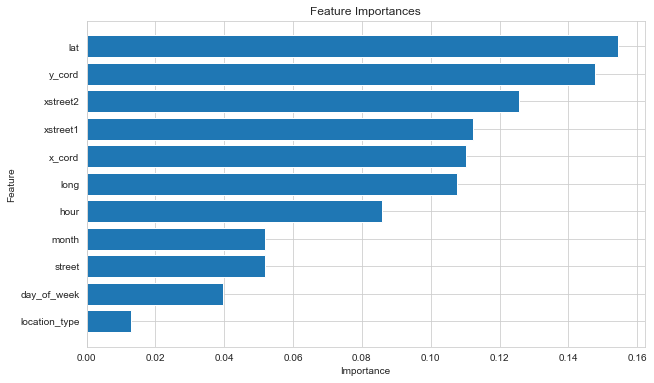

In [14]:
# Get feature importance
feature_importance = best_rf_model.feature_importances_

# Assuming 'X_train' contains training data
feature_names = X_train.columns  # Get the feature names

# Create a DataFrame to store feature importances
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# Sort the DataFrame by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Create a bar plot of feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()


## Lets draw some more conclusions

### Find most accident-prone street intersectinos

In [15]:
# Let's load the data in again and do a simple EDA
data_copy = pd.read_csv(url)

In [16]:
# Convert 'dispatch_ts' to datetime format
data_copy['dispatch_ts'] = pd.to_datetime(data_copy['dispatch_ts'])

# Fill missing values in 'street', 'xstreet1', and 'xstreet2' with "Unknown"
data_copy['street'].fillna('Unknown', inplace=True)
data_copy['xstreet1'].fillna('Unknown', inplace=True)
data_copy['xstreet2'].fillna('Unknown', inplace=True)

In [17]:
# Ensure 'xstreet1' and 'xstreet2' are not 'Unknown'
data_copy.loc[(data_copy['xstreet1'] != 'Unknown') & (data_copy['xstreet2'] != 'Unknown'), 'street_pair'] = data_copy['xstreet1'] + ' & ' + data_copy['xstreet2']

# Find the most common street pairs
top_street_pairs = data_copy['street_pair'].value_counts().head(10)

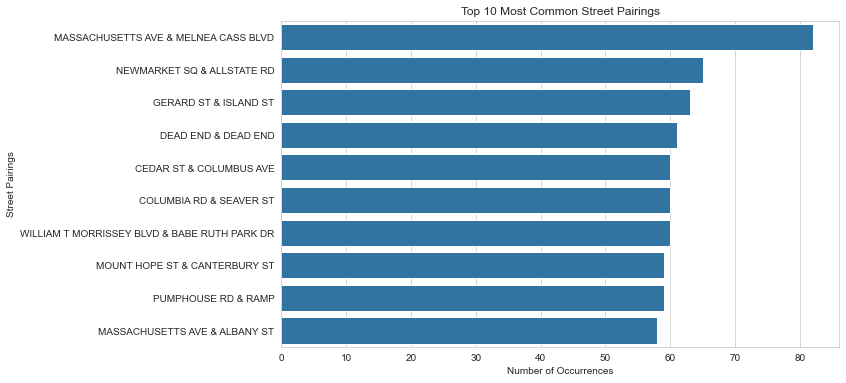

In [18]:
plt.figure(figsize=(10, 6))
sns.barplot(x=top_street_pairs.values, y=top_street_pairs.index)
plt.title('Top 10 Most Common Street Pairings')
plt.xlabel('Number of Occurrences')
plt.ylabel('Street Pairings')
plt.show()

### Find the most common times an accident occurs

In [19]:
# Extracting the hour from the 'dispatch_ts' column
data_copy['hour_of_day'] = data_copy['dispatch_ts'].dt.hour

# Finding the most common hours for accidents
common_accident_times = data_copy['hour_of_day'].value_counts().sort_index()

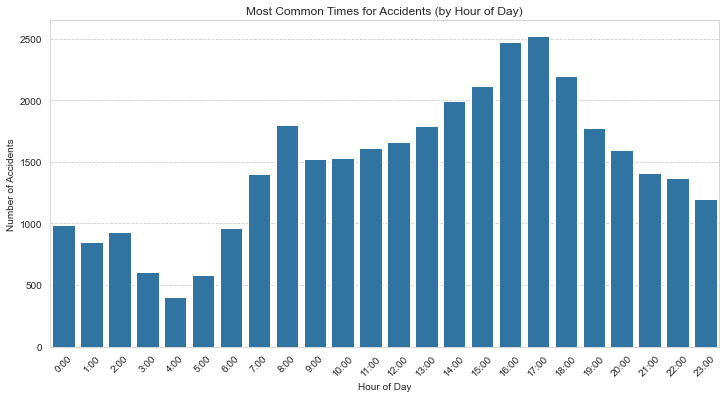

In [20]:
# Plot the times
plt.figure(figsize=(12, 6))
sns.barplot(x=common_accident_times.index, y=common_accident_times.values)
plt.title('Most Common Times for Accidents (by Hour of Day)')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Accidents')
plt.xticks(ticks=range(24), labels=[f"{hour}:00" for hour in range(24)], rotation=45) 
plt.grid(axis='y', linestyle='--')

plt.show()
